In [62]:
!pip install sentence-transformers
!pip install pandas


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable


In [63]:


from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets, evaluation
from torch.utils.data import DataLoader

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import torch
import random
import torch
import random

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

In [64]:
#Load the sprag dataset
data = pd.read_csv("refstdcombined.csv")
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0


In [65]:
data['bin_score'] = data.apply(lambda row : 1 if row.avg_score>=3 else 0, axis=1)

In [66]:
data.head(2)

,Unnamed: 0,QuestionID,ReferenceAnswer,StudentAnswer,Score1,Score2,avg_score,max_score,bin_score
0,0.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tha object structures which can be changeable ...,1.0,0.0,0.5,1.0,0
1,1.0,PythonQ001,"List, Set and Dictionary are mutable data stru...",Tuple,0.0,0.0,0.0,0.0,0


In [67]:
data = data.dropna()

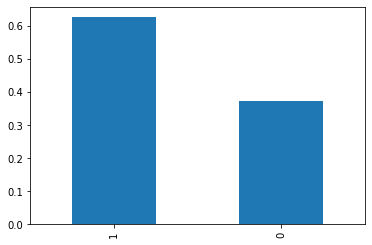

In [68]:
data['bin_score'].value_counts(normalize=True).plot(kind='bar');

In [69]:
#### Just some code to print debug information to stdout
import logging
from sentence_transformers import LoggingHandler
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])

In [70]:
from sklearn.model_selection import train_test_split

# Storing labels in array
labels = data['bin_score'].values

# Dropping labels column from data
data = data.drop(['bin_score'], axis=1)

# Splitting data into train and test sets in a 70/30 ratio
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, stratify=labels, random_state=42, test_size=0.2)

In [72]:
len(train_data)*0.25, type(train_labels), train_labels.shape


(802.0, numpy.ndarray, (3208,))

In [73]:
train_data = train_data.iloc[0:802]
train_labels = train_labels[0:802]

In [74]:
type(train_data), type(train_labels), len(train_data), len(train_labels)

(pandas.core.frame.DataFrame, numpy.ndarray, 802, 802)

In [75]:

def random_deletion(sentence, p=0.2): 
  words = sentence.split()
  if len(words) <= 3:
    return ' '.join(words)
  remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
  if len(remaining) == 0: # if not left, sample a random word
    return ' '.join([random.choice(words)])
  else:
    return ' '.join(remaining)


In [76]:
random_deletion("Hi i am ")

'Hi i am'

In [77]:
def sentence_pairs_generation(sentence1, sentence2, labels, pairs, datatype='train'):
	# initialize two empty lists to hold the (sentence, sentence) pairs and
	# labels to indicate if the grade of the pair

  numClassesList = np.unique(labels)
  #print(numClassesList)
  idx = [np.where(labels == i)[0] for i in numClassesList]
  #print(idx)
  i=0

  for idxA in range(len(sentence1)):      
    dAns = sentence1[idxA]
    sAns = sentence2[idxA]
    label = int(labels[idxA])
    
		  # prepare a pair and update the sentences and labels lists, respectively
    pairs.append(InputExample(texts=[dAns, sAns], label=label))
    
    if datatype=='train' and random.random() >= 0.5:
      sAns = random_deletion(sentence2[idxA])
      #print(sAns)
      pairs.append(InputExample(texts=[dAns, sAns], label=label))
      i = i+1
  
  print("No.of augmented examples : ", i)

     
	# return a 2-tuple of our image pairs and labels
  return (pairs)

In [78]:
set_seed(0)
# Equal samples per class training
#train_df_sample = pd.concat([train_df[train_df[1]==0].sample(num_training), train_df[train_df[1]==1].sample(num_training)])
x_train_dA = train_data['ReferenceAnswer'].values.tolist()
x_train_sA = train_data['StudentAnswer'].values.tolist()
y_train = train_labels.tolist()
y_train = [int(x) for x in y_train]

In [79]:
#use test dataset as dev dataset
x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels / 1.0
y_test = test_labels.tolist()
#y_test = [int(x) for x in y_test]

test_examples = [] 
test_examples = sentence_pairs_generation(np.array(x_test_dA), np.array(x_test_sA), np.array(y_test), test_examples, datatype='test')

No.of augmented examples :  0


In [80]:
len(test_examples)

802

In [81]:
train_examples = [] 
train_examples = sentence_pairs_generation(np.array(x_train_dA), np.array(x_train_sA), np.array(y_train), train_examples)

No.of augmented examples :  420


In [82]:
len(train_examples)

1222

In [83]:
# Save path of the model
from datetime import datetime
model_save_path = 'output/training_sprag_v4_'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

In [84]:
from sentence_transformers import evaluation
import math


def train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs,model_save_path):
  model = SentenceTransformer(st_model)
  #for evaluation
  train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
  #test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
  x_test_dA = test_data['ReferenceAnswer'].values.tolist()
  x_test_sA = test_data['StudentAnswer'].values.tolist()
  y_test = test_labels 

  evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)

  #configuring the training
  warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
  print(warmup_steps)
  #train_loss = losses.CosineSimilarityLoss(model)
  model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          show_progress_bar=True,  
          #evaluation_steps=50, 
          output_path=model_save_path,)
  print("Training done...")

In [85]:
st_model = 'stsb-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:47:37 - Load pretrained SentenceTransformer: stsb-distilbert-base
2022-09-07 19:47:38 - Use pytorch device: cuda
2022-09-07 19:47:38 - Softmax loss: #Vectors concatenated: 3
77


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:47:44 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:47:45 - Accuracy with Cosine-Similarity:           74.94	(Threshold: 0.4509)
2022-09-07 19:47:45 - F1 with Cosine-Similarity:                 82.32	(Threshold: 0.3964)
2022-09-07 19:47:45 - Precision with Cosine-Similarity:          73.82
2022-09-07 19:47:45 - Recall with Cosine-Similarity:             93.04
2022-09-07 19:47:45 - Average Precision with Cosine-Similarity:  87.53

2022-09-07 19:47:45 - Accuracy with Manhattan-Distance:           75.19	(Threshold: 368.8943)
2022-09-07 19:47:45 - F1 with Manhattan-Distance:                 82.40	(Threshold: 368.8943)
2022-09-07 19:47:45 - Precision with Manhattan-Distance:          74.20
2022-09-07 19:47:45 - Recall with Manhattan-Distance:             92.64
2022-09-07 19:47:45 - Average Precision with Manhattan-Distance:  87.93

2022-09-07 19:47:45 - Accuracy with Euclidean-Distance:           75.56	(Threshold: 14.8910)
2022-09-07 19:47:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:47:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:47:52 - Accuracy with Cosine-Similarity:           77.93	(Threshold: 0.4135)
2022-09-07 19:47:52 - F1 with Cosine-Similarity:                 83.71	(Threshold: 0.2877)
2022-09-07 19:47:52 - Precision with Cosine-Similarity:          74.19
2022-09-07 19:47:52 - Recall with Cosine-Similarity:             96.02
2022-09-07 19:47:52 - Average Precision with Cosine-Similarity:  89.21

2022-09-07 19:47:52 - Accuracy with Manhattan-Distance:           77.43	(Threshold: 389.6789)
2022-09-07 19:47:52 - F1 with Manhattan-Distance:                 84.27	(Threshold: 404.7732)
2022-09-07 19:47:52 - Precision with Manhattan-Distance:          74.85
2022-09-07 19:47:52 - Recall with Manhattan-Distance:             96.42
2022-09-07 19:47:52 - Average Precision with Manhattan-Distance:  89.42

2022-09-07 19:47:52 - Accuracy with Euclidean-Distance:           77.56	(Threshold: 17.8607)
2022-09-07 19:47:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:47:59 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:48:00 - Accuracy with Cosine-Similarity:           79.93	(Threshold: 0.3636)
2022-09-07 19:48:00 - F1 with Cosine-Similarity:                 85.35	(Threshold: 0.3522)
2022-09-07 19:48:00 - Precision with Cosine-Similarity:          78.69
2022-09-07 19:48:00 - Recall with Cosine-Similarity:             93.24
2022-09-07 19:48:00 - Average Precision with Cosine-Similarity:  90.12

2022-09-07 19:48:00 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 384.6390)
2022-09-07 19:48:00 - F1 with Manhattan-Distance:                 85.11	(Threshold: 393.3026)
2022-09-07 19:48:00 - Precision with Manhattan-Distance:          79.15
2022-09-07 19:48:00 - Recall with Manhattan-Distance:             92.05
2022-09-07 19:48:00 - Average Precision with Manhattan-Distance:  90.14

2022-09-07 19:48:00 - Accuracy with Euclidean-Distance:           79.93	(Threshold: 17.3152)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:06 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:48:07 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.3646)
2022-09-07 19:48:07 - F1 with Cosine-Similarity:                 84.24	(Threshold: 0.1671)
2022-09-07 19:48:07 - Precision with Cosine-Similarity:          75.27
2022-09-07 19:48:07 - Recall with Cosine-Similarity:             95.63
2022-09-07 19:48:07 - Average Precision with Cosine-Similarity:  89.42

2022-09-07 19:48:07 - Accuracy with Manhattan-Distance:           79.30	(Threshold: 398.2450)
2022-09-07 19:48:07 - F1 with Manhattan-Distance:                 84.49	(Threshold: 417.1031)
2022-09-07 19:48:07 - Precision with Manhattan-Distance:          79.27
2022-09-07 19:48:07 - Recall with Manhattan-Distance:             90.46
2022-09-07 19:48:07 - Average Precision with Manhattan-Distance:  89.45

2022-09-07 19:48:07 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 18.2553)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:13 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:48:14 - Accuracy with Cosine-Similarity:           78.93	(Threshold: 0.3814)
2022-09-07 19:48:14 - F1 with Cosine-Similarity:                 84.57	(Threshold: 0.1382)
2022-09-07 19:48:14 - Precision with Cosine-Similarity:          76.32
2022-09-07 19:48:14 - Recall with Cosine-Similarity:             94.83
2022-09-07 19:48:14 - Average Precision with Cosine-Similarity:  90.03

2022-09-07 19:48:14 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 427.1953)
2022-09-07 19:48:14 - F1 with Manhattan-Distance:                 84.54	(Threshold: 430.9471)
2022-09-07 19:48:14 - Precision with Manhattan-Distance:          79.96
2022-09-07 19:48:14 - Recall with Manhattan-Distance:             89.66
2022-09-07 19:48:14 - Average Precision with Manhattan-Distance:  90.07

2022-09-07 19:48:14 - Accuracy with Euclidean-Distance:           79.43	(Threshold: 19.2938)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:20 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:48:20 - Accuracy with Cosine-Similarity:           79.05	(Threshold: 0.2677)
2022-09-07 19:48:20 - F1 with Cosine-Similarity:                 83.99	(Threshold: 0.2385)
2022-09-07 19:48:20 - Precision with Cosine-Similarity:          79.79
2022-09-07 19:48:20 - Recall with Cosine-Similarity:             88.67
2022-09-07 19:48:20 - Average Precision with Cosine-Similarity:  89.65

2022-09-07 19:48:20 - Accuracy with Manhattan-Distance:           79.30	(Threshold: 436.4941)
2022-09-07 19:48:20 - F1 with Manhattan-Distance:                 84.29	(Threshold: 440.1245)
2022-09-07 19:48:20 - Precision with Manhattan-Distance:          80.00
2022-09-07 19:48:20 - Recall with Manhattan-Distance:             89.07
2022-09-07 19:48:20 - Average Precision with Manhattan-Distance:  89.66

2022-09-07 19:48:20 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 19.9791)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:27 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:48:27 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.2446)
2022-09-07 19:48:27 - F1 with Cosine-Similarity:                 84.07	(Threshold: 0.2446)
2022-09-07 19:48:27 - Precision with Cosine-Similarity:          78.68
2022-09-07 19:48:27 - Recall with Cosine-Similarity:             90.26
2022-09-07 19:48:27 - Average Precision with Cosine-Similarity:  89.54

2022-09-07 19:48:27 - Accuracy with Manhattan-Distance:           79.30	(Threshold: 431.8044)
2022-09-07 19:48:27 - F1 with Manhattan-Distance:                 84.46	(Threshold: 434.5287)
2022-09-07 19:48:27 - Precision with Manhattan-Distance:          79.82
2022-09-07 19:48:27 - Recall with Manhattan-Distance:             89.66
2022-09-07 19:48:27 - Average Precision with Manhattan-Distance:  89.54

2022-09-07 19:48:27 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 19.7281)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:33 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:48:34 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.2937)
2022-09-07 19:48:34 - F1 with Cosine-Similarity:                 83.86	(Threshold: 0.2246)
2022-09-07 19:48:34 - Precision with Cosine-Similarity:          78.61
2022-09-07 19:48:34 - Recall with Cosine-Similarity:             89.86
2022-09-07 19:48:34 - Average Precision with Cosine-Similarity:  89.22

2022-09-07 19:48:34 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 427.4067)
2022-09-07 19:48:34 - F1 with Manhattan-Distance:                 84.13	(Threshold: 439.3651)
2022-09-07 19:48:34 - Precision with Manhattan-Distance:          79.72
2022-09-07 19:48:34 - Recall with Manhattan-Distance:             89.07
2022-09-07 19:48:34 - Average Precision with Manhattan-Distance:  89.24

2022-09-07 19:48:34 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 20.0388)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:40 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:48:41 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.2853)
2022-09-07 19:48:41 - F1 with Cosine-Similarity:                 83.81	(Threshold: 0.1832)
2022-09-07 19:48:41 - Precision with Cosine-Similarity:          77.63
2022-09-07 19:48:41 - Recall with Cosine-Similarity:             91.05
2022-09-07 19:48:41 - Average Precision with Cosine-Similarity:  89.19

2022-09-07 19:48:41 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 435.1666)
2022-09-07 19:48:41 - F1 with Manhattan-Distance:                 84.15	(Threshold: 436.9591)
2022-09-07 19:48:41 - Precision with Manhattan-Distance:          80.07
2022-09-07 19:48:41 - Recall with Manhattan-Distance:             88.67
2022-09-07 19:48:41 - Average Precision with Manhattan-Distance:  89.20

2022-09-07 19:48:41 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 19.3334)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:48:47 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.2962)
2022-09-07 19:48:47 - F1 with Cosine-Similarity:                 83.92	(Threshold: 0.1744)
2022-09-07 19:48:47 - Precision with Cosine-Similarity:          77.26
2022-09-07 19:48:47 - Recall with Cosine-Similarity:             91.85
2022-09-07 19:48:47 - Average Precision with Cosine-Similarity:  89.23

2022-09-07 19:48:47 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 425.2442)
2022-09-07 19:48:47 - F1 with Manhattan-Distance:                 84.15	(Threshold: 435.5705)
2022-09-07 19:48:47 - Precision with Manhattan-Distance:          80.07
2022-09-07 19:48:47 - Recall with Manhattan-Distance:             88.67
2022-09-07 19:48:47 - Average Precision with Manhattan-Distance:  89.26

2022-09-07 19:48:47 - Accuracy with Euclidean-Distance:           79.05	(Threshold: 19.3421)
2022-09-07 19:48:

0.9016983565490617

In [86]:
st_model = 'sentence-transformers/paraphrase-albert-small-v2'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:48:50 - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-albert-small-v2
2022-09-07 19:48:50 - Use pytorch device: cuda
2022-09-07 19:48:50 - Softmax loss: #Vectors concatenated: 3
77


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:48:56 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:48:56 - Accuracy with Cosine-Similarity:           73.07	(Threshold: 0.4604)
2022-09-07 19:48:56 - F1 with Cosine-Similarity:                 80.64	(Threshold: 0.3274)
2022-09-07 19:48:56 - Precision with Cosine-Similarity:          70.15
2022-09-07 19:48:56 - Recall with Cosine-Similarity:             94.83
2022-09-07 19:48:56 - Average Precision with Cosine-Similarity:  86.64

2022-09-07 19:48:56 - Accuracy with Manhattan-Distance:           73.44	(Threshold: 428.3157)
2022-09-07 19:48:56 - F1 with Manhattan-Distance:                 80.93	(Threshold: 428.3157)
2022-09-07 19:48:56 - Precision with Manhattan-Distance:          73.62
2022-09-07 19:48:56 - Recall with Manhattan-Distance:             89.86
2022-09-07 19:48:56 - Average Precision with Manhattan-Distance:  86.39

2022-09-07 19:48:56 - Accuracy with Euclidean-Distance:           73.69	(Threshold: 17.5868)
2022-09-07 19:48:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:02 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:49:03 - Accuracy with Cosine-Similarity:           75.69	(Threshold: 0.5308)
2022-09-07 19:49:03 - F1 with Cosine-Similarity:                 81.72	(Threshold: 0.3832)
2022-09-07 19:49:03 - Precision with Cosine-Similarity:          73.23
2022-09-07 19:49:03 - Recall with Cosine-Similarity:             92.45
2022-09-07 19:49:03 - Average Precision with Cosine-Similarity:  87.92

2022-09-07 19:49:03 - Accuracy with Manhattan-Distance:           75.69	(Threshold: 568.7067)
2022-09-07 19:49:03 - F1 with Manhattan-Distance:                 82.73	(Threshold: 590.1941)
2022-09-07 19:49:03 - Precision with Manhattan-Distance:          73.98
2022-09-07 19:49:03 - Recall with Manhattan-Distance:             93.84
2022-09-07 19:49:03 - Average Precision with Manhattan-Distance:  87.92

2022-09-07 19:49:03 - Accuracy with Euclidean-Distance:           76.06	(Threshold: 25.5882)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:09 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:49:09 - Accuracy with Cosine-Similarity:           77.31	(Threshold: 0.4374)
2022-09-07 19:49:09 - F1 with Cosine-Similarity:                 82.86	(Threshold: 0.4374)
2022-09-07 19:49:09 - Precision with Cosine-Similarity:          78.71
2022-09-07 19:49:09 - Recall with Cosine-Similarity:             87.48
2022-09-07 19:49:09 - Average Precision with Cosine-Similarity:  87.82

2022-09-07 19:49:09 - Accuracy with Manhattan-Distance:           77.81	(Threshold: 640.6286)
2022-09-07 19:49:09 - F1 with Manhattan-Distance:                 83.52	(Threshold: 642.4004)
2022-09-07 19:49:09 - Precision with Manhattan-Distance:          78.16
2022-09-07 19:49:09 - Recall with Manhattan-Distance:             89.66
2022-09-07 19:49:09 - Average Precision with Manhattan-Distance:  88.19

2022-09-07 19:49:09 - Accuracy with Euclidean-Distance:           77.43	(Threshold: 29.1044)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:15 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:49:16 - Accuracy with Cosine-Similarity:           78.93	(Threshold: 0.4107)
2022-09-07 19:49:16 - F1 with Cosine-Similarity:                 84.04	(Threshold: 0.4107)
2022-09-07 19:49:16 - Precision with Cosine-Similarity:          80.04
2022-09-07 19:49:16 - Recall with Cosine-Similarity:             88.47
2022-09-07 19:49:16 - Average Precision with Cosine-Similarity:  88.45

2022-09-07 19:49:16 - Accuracy with Manhattan-Distance:           78.80	(Threshold: 678.1982)
2022-09-07 19:49:16 - F1 with Manhattan-Distance:                 84.26	(Threshold: 679.2531)
2022-09-07 19:49:16 - Precision with Manhattan-Distance:          78.86
2022-09-07 19:49:16 - Recall with Manhattan-Distance:             90.46
2022-09-07 19:49:16 - Average Precision with Manhattan-Distance:  88.70

2022-09-07 19:49:16 - Accuracy with Euclidean-Distance:           78.18	(Threshold: 30.0907)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:22 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:49:22 - Accuracy with Cosine-Similarity:           79.68	(Threshold: 0.3746)
2022-09-07 19:49:22 - F1 with Cosine-Similarity:                 84.40	(Threshold: 0.3746)
2022-09-07 19:49:22 - Precision with Cosine-Similarity:          81.37
2022-09-07 19:49:22 - Recall with Cosine-Similarity:             87.67
2022-09-07 19:49:22 - Average Precision with Cosine-Similarity:  88.48

2022-09-07 19:49:22 - Accuracy with Manhattan-Distance:           79.43	(Threshold: 717.6658)
2022-09-07 19:49:22 - F1 with Manhattan-Distance:                 84.57	(Threshold: 720.5099)
2022-09-07 19:49:22 - Precision with Manhattan-Distance:          79.41
2022-09-07 19:49:22 - Recall with Manhattan-Distance:             90.46
2022-09-07 19:49:22 - Average Precision with Manhattan-Distance:  88.62

2022-09-07 19:49:22 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 32.0637)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:28 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:49:29 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.3772)
2022-09-07 19:49:29 - F1 with Cosine-Similarity:                 83.78	(Threshold: 0.3152)
2022-09-07 19:49:29 - Precision with Cosine-Similarity:          76.61
2022-09-07 19:49:29 - Recall with Cosine-Similarity:             92.45
2022-09-07 19:49:29 - Average Precision with Cosine-Similarity:  89.15

2022-09-07 19:49:29 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 715.5815)
2022-09-07 19:49:29 - F1 with Manhattan-Distance:                 84.77	(Threshold: 762.1392)
2022-09-07 19:49:29 - Precision with Manhattan-Distance:          76.77
2022-09-07 19:49:29 - Recall with Manhattan-Distance:             94.63
2022-09-07 19:49:29 - Average Precision with Manhattan-Distance:  89.32

2022-09-07 19:49:29 - Accuracy with Euclidean-Distance:           78.93	(Threshold: 32.3341)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:34 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:49:35 - Accuracy with Cosine-Similarity:           78.68	(Threshold: 0.3642)
2022-09-07 19:49:35 - F1 with Cosine-Similarity:                 83.88	(Threshold: 0.3642)
2022-09-07 19:49:35 - Precision with Cosine-Similarity:          79.75
2022-09-07 19:49:35 - Recall with Cosine-Similarity:             88.47
2022-09-07 19:49:35 - Average Precision with Cosine-Similarity:  88.99

2022-09-07 19:49:35 - Accuracy with Manhattan-Distance:           78.55	(Threshold: 747.9818)
2022-09-07 19:49:35 - F1 with Manhattan-Distance:                 84.64	(Threshold: 775.3691)
2022-09-07 19:49:35 - Precision with Manhattan-Distance:          76.82
2022-09-07 19:49:35 - Recall with Manhattan-Distance:             94.23
2022-09-07 19:49:35 - Average Precision with Manhattan-Distance:  89.16

2022-09-07 19:49:35 - Accuracy with Euclidean-Distance:           78.55	(Threshold: 32.8552)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:41 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:49:41 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.3974)
2022-09-07 19:49:41 - F1 with Cosine-Similarity:                 83.88	(Threshold: 0.3683)
2022-09-07 19:49:41 - Precision with Cosine-Similarity:          78.95
2022-09-07 19:49:41 - Recall with Cosine-Similarity:             89.46
2022-09-07 19:49:41 - Average Precision with Cosine-Similarity:  88.92

2022-09-07 19:49:41 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 750.4651)
2022-09-07 19:49:41 - F1 with Manhattan-Distance:                 84.64	(Threshold: 750.4651)
2022-09-07 19:49:41 - Precision with Manhattan-Distance:          78.34
2022-09-07 19:49:41 - Recall with Manhattan-Distance:             92.05
2022-09-07 19:49:41 - Average Precision with Manhattan-Distance:  89.10

2022-09-07 19:49:41 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 34.3797)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:47 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:49:47 - Accuracy with Cosine-Similarity:           78.43	(Threshold: 0.3925)
2022-09-07 19:49:47 - F1 with Cosine-Similarity:                 83.89	(Threshold: 0.3531)
2022-09-07 19:49:47 - Precision with Cosine-Similarity:          78.51
2022-09-07 19:49:47 - Recall with Cosine-Similarity:             90.06
2022-09-07 19:49:47 - Average Precision with Cosine-Similarity:  88.94

2022-09-07 19:49:48 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 750.9552)
2022-09-07 19:49:48 - F1 with Manhattan-Distance:                 84.67	(Threshold: 756.5404)
2022-09-07 19:49:48 - Precision with Manhattan-Distance:          78.25
2022-09-07 19:49:48 - Recall with Manhattan-Distance:             92.25
2022-09-07 19:49:48 - Average Precision with Manhattan-Distance:  89.09

2022-09-07 19:49:48 - Accuracy with Euclidean-Distance:           78.93	(Threshold: 34.3741)
2022-09-07 19:49:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:49:53 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:49:54 - Accuracy with Cosine-Similarity:           78.55	(Threshold: 0.3946)
2022-09-07 19:49:54 - F1 with Cosine-Similarity:                 83.86	(Threshold: 0.3583)
2022-09-07 19:49:54 - Precision with Cosine-Similarity:          78.61
2022-09-07 19:49:54 - Recall with Cosine-Similarity:             89.86
2022-09-07 19:49:54 - Average Precision with Cosine-Similarity:  88.93

2022-09-07 19:49:54 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 751.0348)
2022-09-07 19:49:54 - F1 with Manhattan-Distance:                 84.67	(Threshold: 755.4767)
2022-09-07 19:49:54 - Precision with Manhattan-Distance:          78.25
2022-09-07 19:49:54 - Recall with Manhattan-Distance:             92.25
2022-09-07 19:49:54 - Average Precision with Manhattan-Distance:  89.07

2022-09-07 19:49:54 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 34.1858)
2022-09-07 19:49:

0.893463682902669

In [87]:

st_model = 'sentence-transformers/quora-distilbert-base'
num_epochs = 10
batch_size=16
model_save_path = "binary_sim_output/"+st_model
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=batch_size)
  
test_dataloader = DataLoader(test_examples, shuffle=True, batch_size=batch_size)
model = train_and_evaluate(st_model, train_dataloader, test_dataloader, num_epochs, model_save_path)
print("\n\n")
print(" "*20, "*"*10, st_model , "*"*10)

# Load the stored model and evaluate its performance on mohler test dataset
model = SentenceTransformer(model_save_path)
train_loss = losses.SoftmaxLoss(model=model, sentence_embedding_dimension=model.get_sentence_embedding_dimension(), num_labels=2)
test_evaluator = evaluation.EmbeddingSimilarityEvaluator.from_input_examples(test_examples, batch_size=16, name='SPRAG-test')
test_evaluator(model, output_path=model_save_path)
train_loss.cuda()

x_test_dA = test_data['ReferenceAnswer'].values.tolist()
x_test_sA = test_data['StudentAnswer'].values.tolist()
y_test = test_labels 

evaluator = evaluation.BinaryClassificationEvaluator(x_test_dA, x_test_sA, y_test)
evaluator(model, output_path=model_save_path)


2022-09-07 19:49:56 - Load pretrained SentenceTransformer: sentence-transformers/quora-distilbert-base
2022-09-07 19:49:57 - Use pytorch device: cuda
2022-09-07 19:49:57 - Softmax loss: #Vectors concatenated: 3
77


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:03 - Binary Accuracy Evaluation of the model on  dataset after epoch 0:
2022-09-07 19:50:04 - Accuracy with Cosine-Similarity:           76.31	(Threshold: 0.4619)
2022-09-07 19:50:04 - F1 with Cosine-Similarity:                 82.30	(Threshold: 0.4117)
2022-09-07 19:50:04 - Precision with Cosine-Similarity:          76.05
2022-09-07 19:50:04 - Recall with Cosine-Similarity:             89.66
2022-09-07 19:50:04 - Average Precision with Cosine-Similarity:  88.44

2022-09-07 19:50:04 - Accuracy with Manhattan-Distance:           75.19	(Threshold: 292.5936)
2022-09-07 19:50:04 - F1 with Manhattan-Distance:                 81.14	(Threshold: 314.9000)
2022-09-07 19:50:04 - Precision with Manhattan-Distance:          75.21
2022-09-07 19:50:04 - Recall with Manhattan-Distance:             88.07
2022-09-07 19:50:04 - Average Precision with Manhattan-Distance:  86.59

2022-09-07 19:50:04 - Accuracy with Euclidean-Distance:           75.44	(Threshold: 13.6799)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:10 - Binary Accuracy Evaluation of the model on  dataset after epoch 1:
2022-09-07 19:50:11 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.4511)
2022-09-07 19:50:11 - F1 with Cosine-Similarity:                 84.62	(Threshold: 0.3924)
2022-09-07 19:50:11 - Precision with Cosine-Similarity:          79.65
2022-09-07 19:50:11 - Recall with Cosine-Similarity:             90.26
2022-09-07 19:50:11 - Average Precision with Cosine-Similarity:  90.20

2022-09-07 19:50:11 - Accuracy with Manhattan-Distance:           79.18	(Threshold: 341.7511)
2022-09-07 19:50:11 - F1 with Manhattan-Distance:                 84.20	(Threshold: 341.7511)
2022-09-07 19:50:11 - Precision with Manhattan-Distance:          80.32
2022-09-07 19:50:11 - Recall with Manhattan-Distance:             88.47
2022-09-07 19:50:11 - Average Precision with Manhattan-Distance:  89.30

2022-09-07 19:50:11 - Accuracy with Euclidean-Distance:           78.80	(Threshold: 15.6599)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:18 - Binary Accuracy Evaluation of the model on  dataset after epoch 2:
2022-09-07 19:50:18 - Accuracy with Cosine-Similarity:           80.67	(Threshold: 0.3775)
2022-09-07 19:50:18 - F1 with Cosine-Similarity:                 85.66	(Threshold: 0.3775)
2022-09-07 19:50:18 - Precision with Cosine-Similarity:          80.10
2022-09-07 19:50:18 - Recall with Cosine-Similarity:             92.05
2022-09-07 19:50:18 - Average Precision with Cosine-Similarity:  91.38

2022-09-07 19:50:18 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 365.6235)
2022-09-07 19:50:18 - F1 with Manhattan-Distance:                 85.33	(Threshold: 373.7770)
2022-09-07 19:50:18 - Precision with Manhattan-Distance:          78.37
2022-09-07 19:50:18 - Recall with Manhattan-Distance:             93.64
2022-09-07 19:50:18 - Average Precision with Manhattan-Distance:  90.63

2022-09-07 19:50:18 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 17.2563)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:25 - Binary Accuracy Evaluation of the model on  dataset after epoch 3:
2022-09-07 19:50:25 - Accuracy with Cosine-Similarity:           81.17	(Threshold: 0.4762)
2022-09-07 19:50:25 - F1 with Cosine-Similarity:                 85.77	(Threshold: 0.4594)
2022-09-07 19:50:25 - Precision with Cosine-Similarity:          81.54
2022-09-07 19:50:25 - Recall with Cosine-Similarity:             90.46
2022-09-07 19:50:25 - Average Precision with Cosine-Similarity:  90.77

2022-09-07 19:50:25 - Accuracy with Manhattan-Distance:           80.05	(Threshold: 368.6294)
2022-09-07 19:50:25 - F1 with Manhattan-Distance:                 85.32	(Threshold: 373.1897)
2022-09-07 19:50:25 - Precision with Manhattan-Distance:          79.22
2022-09-07 19:50:25 - Recall with Manhattan-Distance:             92.45
2022-09-07 19:50:25 - Average Precision with Manhattan-Distance:  90.64

2022-09-07 19:50:25 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 15.4380)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:32 - Binary Accuracy Evaluation of the model on  dataset after epoch 4:
2022-09-07 19:50:32 - Accuracy with Cosine-Similarity:           79.30	(Threshold: 0.1907)
2022-09-07 19:50:32 - F1 with Cosine-Similarity:                 84.91	(Threshold: 0.1818)
2022-09-07 19:50:32 - Precision with Cosine-Similarity:          78.22
2022-09-07 19:50:32 - Recall with Cosine-Similarity:             92.84
2022-09-07 19:50:32 - Average Precision with Cosine-Similarity:  89.86

2022-09-07 19:50:32 - Accuracy with Manhattan-Distance:           78.93	(Threshold: 445.3909)
2022-09-07 19:50:32 - F1 with Manhattan-Distance:                 84.82	(Threshold: 448.2977)
2022-09-07 19:50:32 - Precision with Manhattan-Distance:          77.38
2022-09-07 19:50:32 - Recall with Manhattan-Distance:             93.84
2022-09-07 19:50:32 - Average Precision with Manhattan-Distance:  89.55

2022-09-07 19:50:32 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 20.1429)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:38 - Binary Accuracy Evaluation of the model on  dataset after epoch 5:
2022-09-07 19:50:39 - Accuracy with Cosine-Similarity:           79.80	(Threshold: 0.3437)
2022-09-07 19:50:39 - F1 with Cosine-Similarity:                 84.90	(Threshold: 0.1375)
2022-09-07 19:50:39 - Precision with Cosine-Similarity:          76.73
2022-09-07 19:50:39 - Recall with Cosine-Similarity:             95.03
2022-09-07 19:50:39 - Average Precision with Cosine-Similarity:  90.02

2022-09-07 19:50:39 - Accuracy with Manhattan-Distance:           79.05	(Threshold: 417.5568)
2022-09-07 19:50:39 - F1 with Manhattan-Distance:                 84.96	(Threshold: 469.2950)
2022-09-07 19:50:39 - Precision with Manhattan-Distance:          76.18
2022-09-07 19:50:39 - Recall with Manhattan-Distance:             96.02
2022-09-07 19:50:39 - Average Precision with Manhattan-Distance:  89.92

2022-09-07 19:50:39 - Accuracy with Euclidean-Distance:           79.18	(Threshold: 18.3206)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:45 - Binary Accuracy Evaluation of the model on  dataset after epoch 6:
2022-09-07 19:50:45 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.5100)
2022-09-07 19:50:45 - F1 with Cosine-Similarity:                 85.23	(Threshold: 0.5100)
2022-09-07 19:50:45 - Precision with Cosine-Similarity:          80.89
2022-09-07 19:50:45 - Recall with Cosine-Similarity:             90.06
2022-09-07 19:50:45 - Average Precision with Cosine-Similarity:  90.29

2022-09-07 19:50:45 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 340.1946)
2022-09-07 19:50:45 - F1 with Manhattan-Distance:                 85.19	(Threshold: 390.1080)
2022-09-07 19:50:45 - Precision with Manhattan-Distance:          78.85
2022-09-07 19:50:45 - Recall with Manhattan-Distance:             92.64
2022-09-07 19:50:45 - Average Precision with Manhattan-Distance:  90.30

2022-09-07 19:50:45 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 15.4813)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:52 - Binary Accuracy Evaluation of the model on  dataset after epoch 7:
2022-09-07 19:50:52 - Accuracy with Cosine-Similarity:           80.05	(Threshold: 0.4182)
2022-09-07 19:50:52 - F1 with Cosine-Similarity:                 85.02	(Threshold: 0.4182)
2022-09-07 19:50:52 - Precision with Cosine-Similarity:          80.35
2022-09-07 19:50:52 - Recall with Cosine-Similarity:             90.26
2022-09-07 19:50:52 - Average Precision with Cosine-Similarity:  89.68

2022-09-07 19:50:52 - Accuracy with Manhattan-Distance:           79.93	(Threshold: 380.8543)
2022-09-07 19:50:52 - F1 with Manhattan-Distance:                 84.87	(Threshold: 396.4691)
2022-09-07 19:50:52 - Precision with Manhattan-Distance:          79.62
2022-09-07 19:50:52 - Recall with Manhattan-Distance:             90.85
2022-09-07 19:50:52 - Average Precision with Manhattan-Distance:  89.73

2022-09-07 19:50:52 - Accuracy with Euclidean-Distance:           80.05	(Threshold: 17.6248)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:50:58 - Binary Accuracy Evaluation of the model on  dataset after epoch 8:
2022-09-07 19:50:59 - Accuracy with Cosine-Similarity:           80.42	(Threshold: 0.4732)
2022-09-07 19:50:59 - F1 with Cosine-Similarity:                 85.23	(Threshold: 0.4706)
2022-09-07 19:50:59 - Precision with Cosine-Similarity:          80.89
2022-09-07 19:50:59 - Recall with Cosine-Similarity:             90.06
2022-09-07 19:50:59 - Average Precision with Cosine-Similarity:  89.74

2022-09-07 19:50:59 - Accuracy with Manhattan-Distance:           80.30	(Threshold: 369.9520)
2022-09-07 19:50:59 - F1 with Manhattan-Distance:                 85.12	(Threshold: 370.5976)
2022-09-07 19:50:59 - Precision with Manhattan-Distance:          80.86
2022-09-07 19:50:59 - Recall with Manhattan-Distance:             89.86
2022-09-07 19:50:59 - Average Precision with Manhattan-Distance:  89.77

2022-09-07 19:50:59 - Accuracy with Euclidean-Distance:           80.42	(Threshold: 17.0011)
2022-09-07 19:50:

Iteration:   0%|          | 0/77 [00:00<?, ?it/s]

2022-09-07 19:51:05 - Binary Accuracy Evaluation of the model on  dataset after epoch 9:
2022-09-07 19:51:05 - Accuracy with Cosine-Similarity:           80.30	(Threshold: 0.4643)
2022-09-07 19:51:05 - F1 with Cosine-Similarity:                 85.12	(Threshold: 0.4643)
2022-09-07 19:51:05 - Precision with Cosine-Similarity:          80.86
2022-09-07 19:51:05 - Recall with Cosine-Similarity:             89.86
2022-09-07 19:51:05 - Average Precision with Cosine-Similarity:  89.70

2022-09-07 19:51:05 - Accuracy with Manhattan-Distance:           80.17	(Threshold: 369.2143)
2022-09-07 19:51:05 - F1 with Manhattan-Distance:                 85.01	(Threshold: 370.0088)
2022-09-07 19:51:05 - Precision with Manhattan-Distance:          80.82
2022-09-07 19:51:05 - Recall with Manhattan-Distance:             89.66
2022-09-07 19:51:05 - Average Precision with Manhattan-Distance:  89.73

2022-09-07 19:51:05 - Accuracy with Euclidean-Distance:           80.30	(Threshold: 17.1013)
2022-09-07 19:51:

0.9137529838469359

In [88]:
#Our sentences we like to encode
s1 = model.encode("Python is an object oriented programming language")
s2 = model.encode("java is an oop language")

s1.shape

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(768,)

In [89]:
#Compute cosine similarity between all pairs
from sentence_transformers import util
cos_sim = util.cos_sim(s1, s2)
cos_sim

tensor([[0.2412]])